# Strava Mileage Analysis
### Author: Oliver Gladfelter
### Jan 7, 2021

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment',None)

### Functions

In [2]:
# convert string datetime stamp to date object
def dateConvert(value):
    return datetime.strptime(value, '%b %d, %Y, %H:%M:%S %p').date()

# Retrieve year from date column 
def getYear(value):
    return str(value)[:4]

# ensure dates are date objects, not strings
def convert(value):
    return value.date()

# extract month and year (YY format) from date objects
def getMonth(value):
    return value.strftime("%b '%y")

### Basic Data Prep

In [3]:
# read data provided by Strava
df = pd.read_csv("activities.csv")

# remove bike rides and other non-running activities
df = df[df['Activity Type']=='Run']
df=df.reset_index()
del df['index']

# convert km to miles
df['miles'] = df['Distance'] * 0.621371

# convert date format
df['date'] = df['Activity Date'].apply(dateConvert)

# only need these 2 columns
df = df[["date", "miles"]]

# groupby date column to combine mileage on days I recorded 2+ separate runs
df = df.groupby('date').sum()
df = df.reset_index()

### Fill In Missing Dates: currently, there are no rows representing dates when I didn't run. For plotting purposes, let's add a row for every date, even when miles run == 0.

In [4]:
dates = pd.date_range(start=df['date'].min(), end=df['date'].max()) # make list of dates, where min and max correspond to df
dates = pd.DataFrame({'date':dates}) # convert to df
dates = dates[dates['date']>="2018-11-29"] # this is the date I registered with Strava 
dates = dates.reset_index()
del dates['index']

# ensure dates are date objects, not strings
dates['date'] = dates['date'].apply(convert)

# left merge dates with df, fill in missing rows with 0
runs = dates.merge(df, how='left').sort_values('date', ascending=True).fillna(0)

In [5]:
# sanity check - how many miles have I run each year?
runs['year'] = runs['date'].apply(getYear)
runs.groupby('year').sum()[['miles']]

,miles
year,
2018,148.836996
2019,1057.349748
2020,1108.550719


### Save data from 2019 and 2020 for the D3.js interactive lineplot

In [6]:
runs[runs['year'] == '2019'][['date', 'miles']].to_csv("Interactive_Mileage_Growth_Lineplot/2019_mileage.csv", index=False)
runs[runs['year'] == '2020'][['date', 'miles']].to_csv("Interactive_Mileage_Growth_Lineplot/2020_mileage.csv", index=False)

### Compute cumulative mileage

In [7]:
runs['totalMiles'] = runs['miles'][0]

for num in range(1,len(runs)):
    runs['totalMiles'][num] = runs['totalMiles'][num-1] + runs['miles'][num]

### Create month label for x-axis

In [8]:
# extract month and year (YY format) from date objects
runs['month'] = runs['date'].apply(getMonth)

# create x-axis tick label for upcoming lineplot
# for clean view, we only want the first day of each new month labeled
runs['monthLabel'] = ''
runs['monthLabel'][0] = "Nov '18"

for num in range(1,len(runs)):
    if runs['month'][num] != runs['month'][num-1]:
        runs['monthLabel'][num] = runs['month'][num]

# Data Viz

### Scatterplot of runs

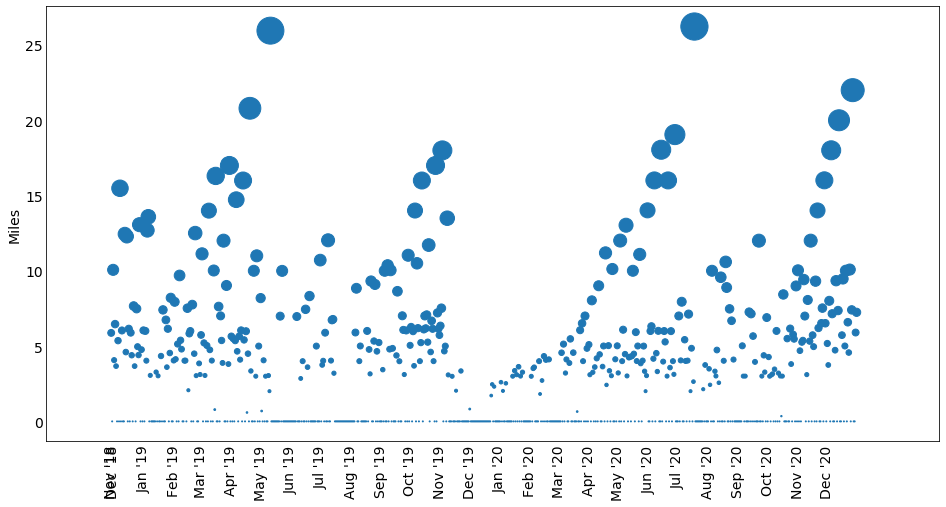

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# plt parameters for all graphs in notebook
font = {'size'   : 14}
plt.rc('font', **font)
plt.figure(figsize=(16,8))

plt.scatter(runs['date'], runs['miles'], s=(runs['miles'] + 1) ** 2)
plt.xticks(runs['date'], runs['monthLabel'])
plt.xticks(rotation=90)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.ylabel("Miles")
plt.show()

### Cumulative miles bubble plot

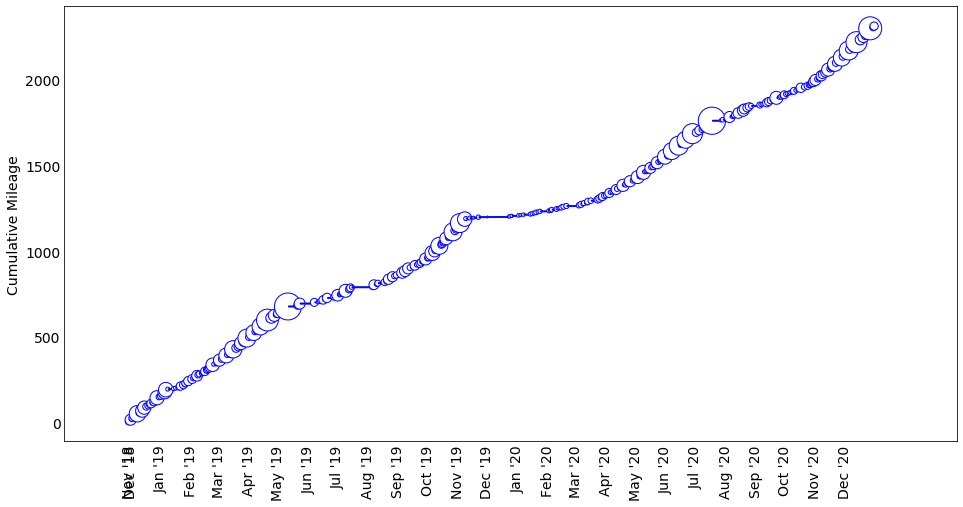

In [10]:
plt.figure(figsize=(16,8))

plt.scatter(runs['date'], runs['totalMiles'], s=(runs['miles'] + 1) ** 2, c='white', edgecolor='blue')

plt.xticks(runs['date'], runs['monthLabel'])
plt.xticks(rotation=90)

plt.tick_params(axis=u'both', which=u'both',length=0)

plt.ylabel("Cumulative Mileage")

plt.show()

### Cumulative miles lineplot for just one year

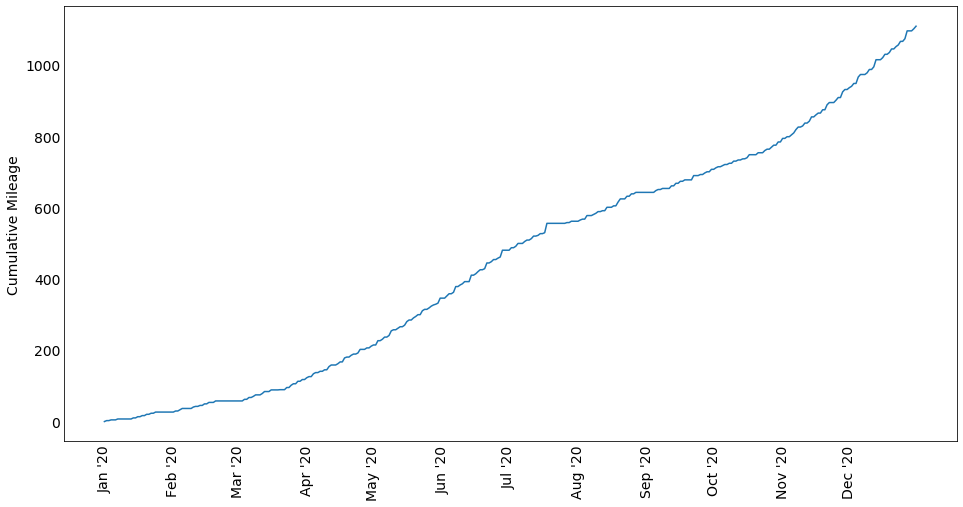

In [11]:
# select year
thisYear = runs[runs['year']=='2020']

# reset totalMiles at 0 for beginning of the year
thisYear['totalMiles'] = thisYear['totalMiles'] - thisYear['totalMiles'].min()

# plot
plt.figure(figsize=(16,8))
plt.plot(thisYear['date'], thisYear['totalMiles'])
plt.xticks(thisYear['date'], thisYear['monthLabel'])
plt.xticks(rotation=90)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.ylabel("Cumulative Mileage")
plt.show()

# Month-Level Analysis

In [12]:
# produce index column and group by month, getting first row (for sorting by chronological purposes later)
runsByMonth_0 = runs.reset_index().groupby('month').first().reset_index()[['month', 'index']]

# get monthly mileage totals
runsByMonth_1 = runs.groupby('month').sum().reset_index()

# merge together
runsByMonth = pd.merge(runsByMonth_0, runsByMonth_1, on='month')[['month', 'index', 'miles']]

# reset index and recreate index colum that begins at 0
runsByMonth = runsByMonth.sort_values('index')
del runsByMonth['index']
runsByMonth = runsByMonth.reset_index()
del runsByMonth['index']
runsByMonth = runsByMonth.reset_index()

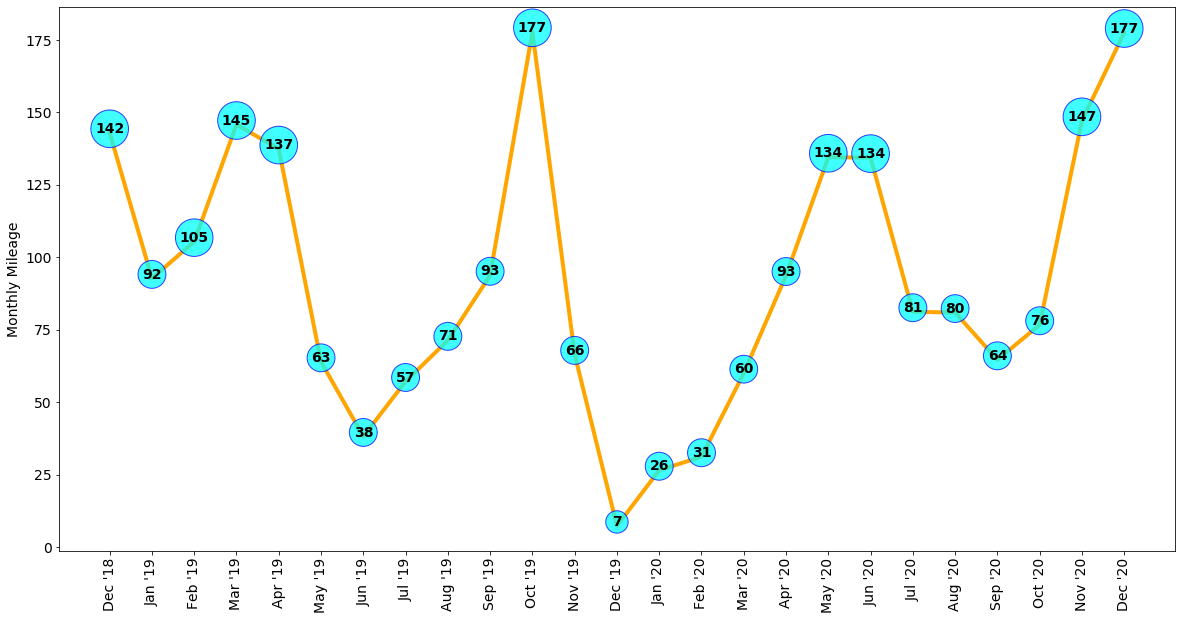

In [13]:
noNov = runsByMonth[1:]

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(noNov['index'], noNov['miles'], color='orange', linewidth = 4)

plt.xticks(noNov['index'], noNov['month'])
plt.xticks(rotation=90)

plt.ylabel("Monthly Mileage")

props = dict(facecolor='cyan', alpha=0.75, edgecolor='blue', boxstyle='circle')

for i in range(1,len(noNov)+1):
    ax.annotate(int(noNov['miles'][i]), (noNov['index'][i], noNov['miles'][i]), ha='center', fontweight='bold', bbox=props)

# Week-Level Analysis

In [14]:
# replace index with date column
df.index = pd.to_datetime(df.date)

# group by week; each row now = one week
runsByWeek = df.resample('W').sum()

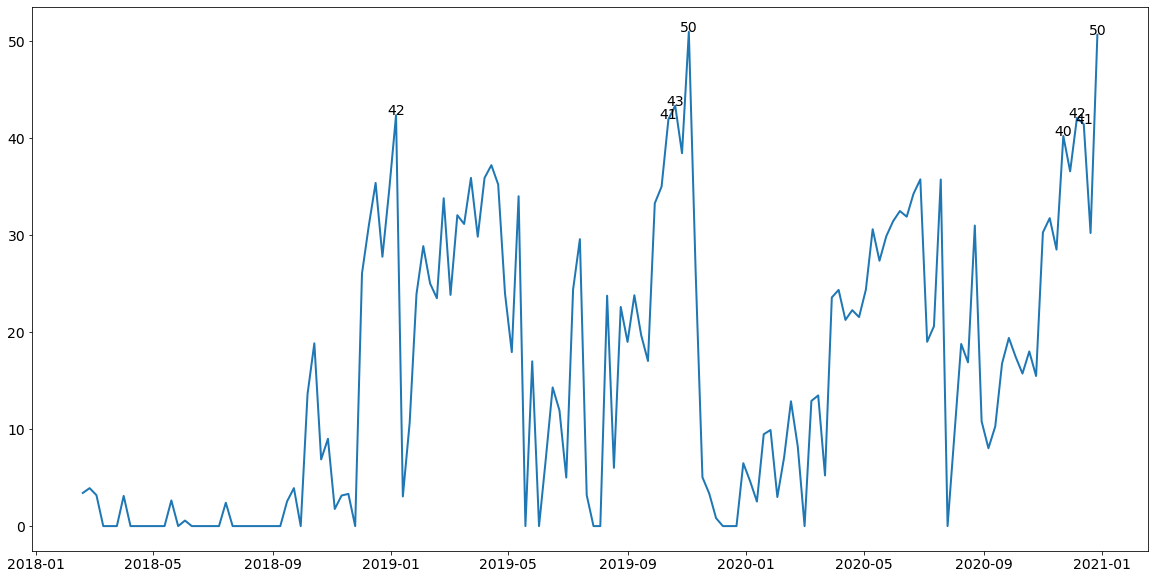

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(runsByWeek.index[:-1], runsByWeek['miles'][:-1], linewidth=2)

for i in range(0,len(runsByWeek)):
    if runsByWeek['miles'][i] >= 40:
        ax.annotate(int(runsByWeek['miles'][i]), (runsByWeek.index[i], runsByWeek['miles'][i]), ha='center')